# MLP for just the first cases

In [1]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import numpy as np

In [3]:
path = r'TF_HLC'

In [4]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

TTF_data = TTF_data
Vs_data = Vs_data

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(1000, 1000) (1000, 141) (1000,)


In [5]:

#scaler = MaxAbsScaler()
#TTF_values = scaler.fit_transform(TTF_data.T).T
#print(TTF_values.shape)

def normalization(data):
    return np.log10(data)

def denormalization(data):
    return 10**data



Text(0, 0.5, 'TTF [s]')

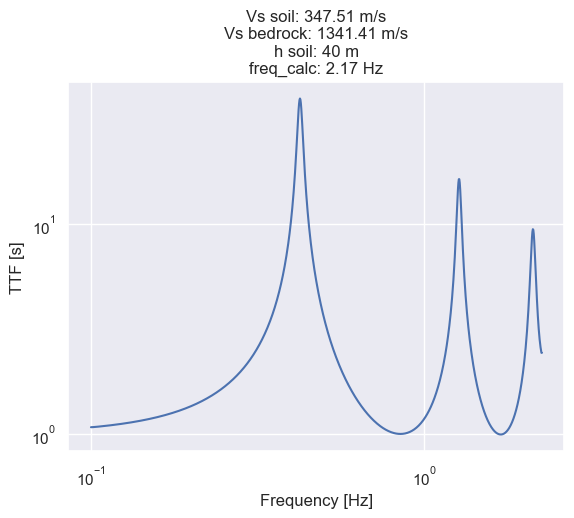

In [6]:
normalized_TTF_data = False

if normalized_TTF_data:
    TTF_values = normalization(TTF_data)
else:
    TTF_values = TTF_data

def text_plot(Vs):
    # Eliminate the nan at the end of the array
    Vs = Vs[~np.isnan(Vs)]
    vs_soil = Vs[0]
    h_soil = len(Vs[:-1])
    vs_bedrock = Vs[-1]
    return f"Vs soil: {vs_soil:.2f} m/s\nVs bedrock: {vs_bedrock:.2f} m/s\nh soil: {h_soil} m\nfreq_calc: {vs_soil/(4*h_soil):.2f} Hz"


idx = 1
plt.loglog(freq_data, TTF_values[idx,:], label="TTF")
plt.title(text_plot(Vs_data[idx,:]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF [s]")
    

In [7]:
# Convert all nan values to 0
Vs = np.nan_to_num(Vs_data, nan=0.0, posinf=0.0, neginf=0.0)

In [8]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = np.nan_to_num(self.Vs_values[idx], nan=0.0, posinf=0.0, neginf=0.0)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [ ]:
dataset = TTF_dataset(TTF_values, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.5 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  1000
Data shapes for input and target:  torch.Size([141, 1]) torch.Size([1000])
Train, validation and test sizes:  500 250 250
Number of batches:  10 5 5


In [ ]:
X,y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([50, 141, 1]) torch.Size([50, 1000])


# Model

In [11]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [12]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

In [13]:
# Let's do a RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, device="cpu"):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)   
        out = self.fc(out[:, -1, :])
        return out  

In [14]:
# Sequence-to-sequence model
# Encoder RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h1 = self.gru(x, h0)
        return out, h1

# Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.rnn(x, hidden)
        return outputs, hidden

In [15]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [16]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderRNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        rnn_input = torch.cat([x, context], 2)
        outputs, hidden = self.rnn(rnn_input, hidden)
        return outputs, hidden

In [17]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

# Define the Decoder LSTM with Attention
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, (hidden, cell) = self.lstm(lstm_input, hidden)
        return outputs, (hidden, cell)


In [18]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden


class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderGRUWithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderGRUWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden

In [19]:
class EncoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        cell = self._cat_directions(cell)
        return outputs, (hidden, cell)

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, (hidden, cell) = self.lstm(x, hidden)
        return outputs, (hidden, cell)

In [20]:
class DecoderBiLSTMwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiLSTMwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        print("x shape: ", x.shape)
        print("hidden shape: ", hidden[0].shape)
        print("encoder_outputs shape: ", encoder_outputs.shape)
        attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        print("attn_weights shape: ", attn_weights.shape)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        outputs, hidden = self.lstm(lstm_input, hidden)
        return outputs, hidden

In [21]:
class EncoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        # Concatenate the hidden states from both directions
        hidden = self._cat_directions(hidden)
        return outputs, hidden

    def _cat_directions(self, h):
        # [num_layers * num_directions, batch, hidden_size] -> [num_layers, batch, hidden_size * num_directions]
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
        return h

class DecoderBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(DecoderBiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x, hidden):
        outputs, hidden = self.gru(x, hidden)
        return outputs, hidden

class DecoderBiGRUwithAttention(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DecoderBiGRUwithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        outputs, hidden = self.gru(gru_input, hidden)
        return outputs, hidden
        

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d
        self.cnn_1d_out = cnn_1d_out

    def forward(self, x, device="cpu", print_shapes=False):
        # Replace Nan values with 0
        x = torch.nan_to_num(x, nan=0.0)


        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN-in output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        if self.cnn_1d_out:
            output = self.cnn_1d_out(output)
            output = output.permute(0, 2, 1)
            if print_shapes:
                print("CNN-out output shape: ", output.shape)
        else:
            output = output.squeeze(1)
            if print_shapes:
                print("Squeezed output shape: ", output.shape)

        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [23]:
# CNN Hyperparameters - In
input_size_cnn = 1
kernel_size = 2
hidden_dim_cnn = 10
hidden_layers_cnn = 2

# CNN Hyperparameters - Out
hidden_dim_cnn_out = 10
hidden_layers_cnn_out = 1


# Encoder and Decoder hyperparameters
input_size = 1 # Given the size of [batch_size, sequence_length, input_size] 
hidden_size = 100
num_layers = 3
encoder_bidirectional = True

# MLP hyperparameters
num_layers_fc = 3
hidden_size_fc = 200
output_size = 1000

# Check bidirectional



In [24]:
# Model
cnn_1d = CNN_1D(input_size_cnn, kernel_size, hidden_dim_cnn, hidden_layers_cnn)
encoder = EncoderBiLSTM(input_size, hidden_size, num_layers)
if hasattr(encoder, 'bidirectional') and encoder.bidirectional:
    hidden_size *= 2
decoder = DecoderLSTMWithAttention(hidden_size, 1, num_layers)
cnn_1d_out = CNN_1D(1, 2, hidden_dim_cnn_out, hidden_layers_cnn_out)
mlp = MLP(200, hidden_size_fc, num_layers_fc, output_size)

model = Seq2Seq(encoder, decoder, mlp, cnn_1d=None, cnn_1d_out=None)

In [25]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 141, 1]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 141, 1])
Encoder outputs shape:  torch.Size([50, 141, 200])
Hidden state shape:  torch.Size([3, 50, 200])
Cell state shape:  torch.Size([3, 50, 200])
Decoder input shape:  torch.Size([50, 1, 200])
Decoder output shape:  torch.Size([50, 1, 200])
Squeezed output shape:  torch.Size([50, 200])
MLP output shape:  torch.Size([50, 1000])
Model output shape:  torch.Size([50, 1000])
tensor(19.3269, grad_fn=<MseLossBackward0>)


In [26]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [27]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, normalize=False):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            if normalize:
                y_pred = denormalization(y_pred)
                y = denormalization(y)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                if normalize:
                    y_pred = denormalization(y_pred)
                    y = denormalization(y)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", normalize=False):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalize:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [28]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.7, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

# Join L1Loss and cosine similarity
def custom_loss(y_true, y_pred, alpha=0.5):
    l1_loss = loss_fn(y_true, y_pred)
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(y_true, y_pred).mean()
    return alpha * l1_loss + (1 - alpha) * cosine_loss

Device:  cuda


In [29]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, custom_loss, 
epochs=num_epochs, device=device, patience=1500, clipping=True, print_epoch=1000, normalize=normalized_TTF_data)

Training:   0%|          | 1/20000 [00:01<8:04:20,  1.45s/epoch]

Epoch 0, Train Loss: 1.7062736988067626, Val Loss: 1.4836959362030029, LR: 0.0005


Training:   5%|▌         | 1001/20000 [27:56<1:20:30,  3.93epoch/s, EarlyStopping counter: 4 out of 1500]   

Epoch 1000, Train Loss: 0.3233227014541626, Val Loss: 0.3919959723949432, LR: 0.0005


Training:  10%|█         | 2001/20000 [33:54<1:15:33,  3.97epoch/s, EarlyStopping counter: 1 out of 1500] 

Epoch 2000, Train Loss: 0.2541009932756424, Val Loss: 0.32846890687942504, LR: 0.0005


Training:  15%|█▌        | 3001/20000 [38:10<1:11:44,  3.95epoch/s, EarlyStopping counter: 4 out of 1500]  

Epoch 3000, Train Loss: 0.20581915527582167, Val Loss: 0.2889612317085266, LR: 0.0005


Training:  20%|██        | 4001/20000 [43:52<2:24:57,  1.84epoch/s, EarlyStopping counter: 52 out of 1500] 

Epoch 4000, Train Loss: 0.2068890631198883, Val Loss: 0.3058042347431183, LR: 0.0005


Training:  25%|██▌       | 5001/20000 [49:00<1:06:06,  3.78epoch/s, EarlyStopping counter: 100 out of 1500]

Epoch 5000, Train Loss: 0.19762356728315353, Val Loss: 0.2999568819999695, LR: 0.0005


Training:  30%|███       | 6001/20000 [53:17<58:57,  3.96epoch/s, EarlyStopping counter: 144 out of 1500]  

Epoch 6000, Train Loss: 0.128877704590559, Val Loss: 0.23866809010505677, LR: 0.0005


Training:  35%|███▌      | 7001/20000 [57:45<1:07:06,  3.23epoch/s, EarlyStopping counter: 791 out of 1500]

Epoch 7000, Train Loss: 0.18978842422366143, Val Loss: 0.3091757118701935, LR: 0.0005


Training:  40%|████      | 8001/20000 [1:02:29<59:01,  3.39epoch/s, EarlyStopping counter: 53 out of 1500]   

Epoch 8000, Train Loss: 0.10516518577933312, Val Loss: 0.232045516371727, LR: 0.00025


Training:  45%|████▌     | 9001/20000 [1:07:30<53:16,  3.44epoch/s, EarlyStopping counter: 627 out of 1500]  

Epoch 9000, Train Loss: 0.0998810775578022, Val Loss: 0.22513262629508973, LR: 0.00025


Training:  50%|█████     | 10001/20000 [1:12:22<48:54,  3.41epoch/s, EarlyStopping counter: 114 out of 1500]

Epoch 10000, Train Loss: 0.09112819135189057, Val Loss: 0.2189413368701935, LR: 0.000125


Training:  55%|█████▌    | 11001/20000 [1:17:59<39:05,  3.84epoch/s, EarlyStopping counter: 79 out of 1500]   

Epoch 11000, Train Loss: 0.07960890308022499, Val Loss: 0.21632167994976043, LR: 0.000125


Training:  60%|██████    | 12001/20000 [1:22:51<35:47,  3.72epoch/s, EarlyStopping counter: 128 out of 1500] 

Epoch 12000, Train Loss: 0.07395767383277416, Val Loss: 0.21473526060581208, LR: 0.000125


Training:  65%|██████▌   | 13001/20000 [1:27:43<29:53,  3.90epoch/s, EarlyStopping counter: 1128 out of 1500]

Epoch 13000, Train Loss: 0.07056156247854233, Val Loss: 0.2141576111316681, LR: 6.25e-05


Training:  67%|██████▋   | 13372/20000 [1:29:28<44:21,  2.49epoch/s, EarlyStopping counter: 1500 out of 1500]

Early stopping


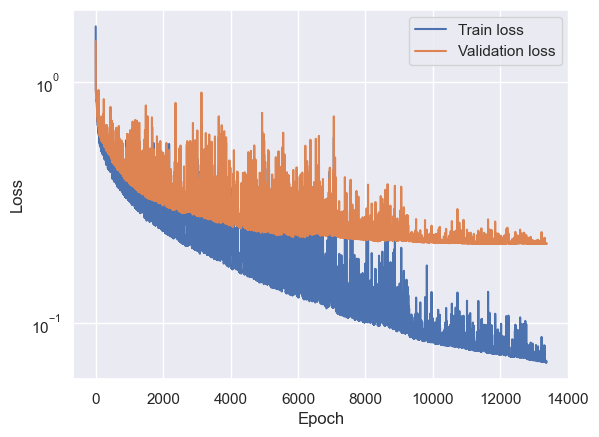

In [30]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [31]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device, normalize=normalized_TTF_data)
print("Test loss: ", test_loss)

Test loss:  0.354814875125885


In [32]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

# Undo log transformation
if normalized_TTF_data:
    target = denormalization(target)
    predicted = denormalization(predicted)

print(target.shape, predicted.shape, Vs_data.shape)

(250, 1000) (250, 1000) (250, 141, 1)


In [33]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

corr_array = []
for i in range(target.shape[0]):
    text_Vs = Vs_data[i,0,:]
    text_Vs = text_Vs[ text_Vs != 0]
    corr_array.append(pearsonr(target[i], predicted[i])[0])

    print("Correlation factor for TTF ", i,"and Vs ", str(text_Vs[0]), " with ",str(len(text_Vs)*5), " m and Vs_bedrock ", 
    str(text_Vs[-1]), " m/s : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  155.66797  with  5  m and Vs_bedrock  155.66797  m/s :  0.9058249736129653
Correlation factor for TTF  1 and Vs  276.71237  with  5  m and Vs_bedrock  276.71237  m/s :  0.9418681779904432
Correlation factor for TTF  2 and Vs  225.19183  with  5  m and Vs_bedrock  225.19183  m/s :  0.9990524727628245
Correlation factor for TTF  3 and Vs  291.02988  with  5  m and Vs_bedrock  291.02988  m/s :  0.9935417432811136
Correlation factor for TTF  4 and Vs  353.11072  with  5  m and Vs_bedrock  353.11072  m/s :  0.9667227544648878
Correlation factor for TTF  5 and Vs  235.33533  with  5  m and Vs_bedrock  235.33533  m/s :  0.9977737048101396
Correlation factor for TTF  6 and Vs  123.895485  with  5  m and Vs_bedrock  123.895485  m/s :  0.8740653182085758
Correlation factor for TTF  7 and Vs  221.3001  with  5  m and Vs_bedrock  221.3001  m/s :  0.991345702140038
Correlation factor for TTF  8 and Vs  168.35886  with  5  m and Vs_bedrock  168.35886  m/s :  0.9

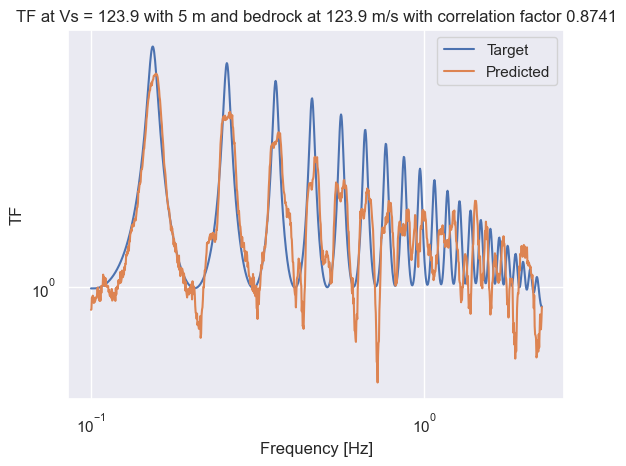

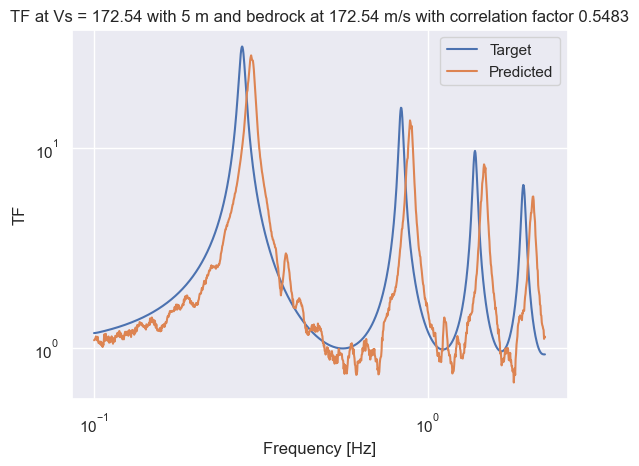

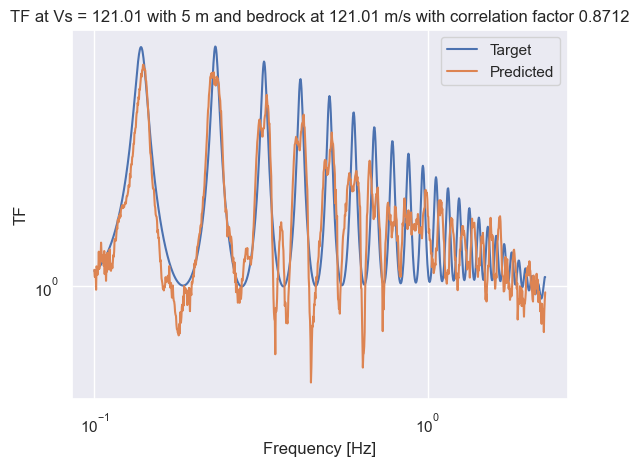

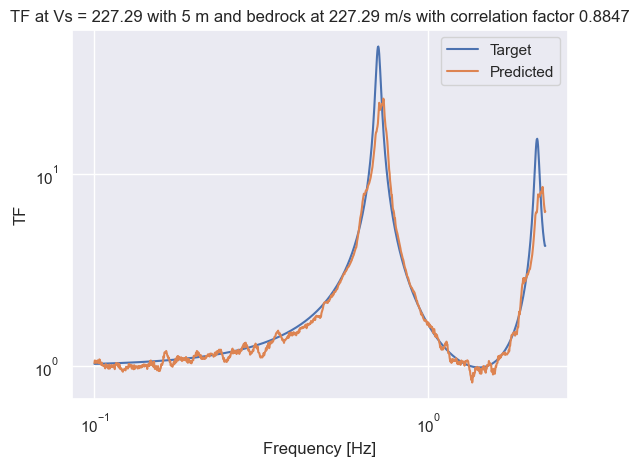

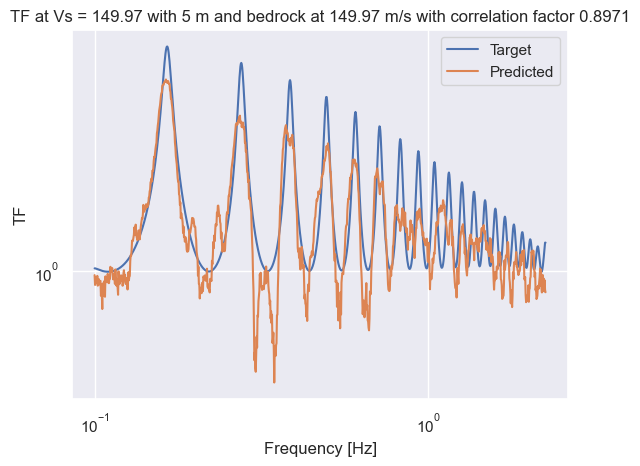

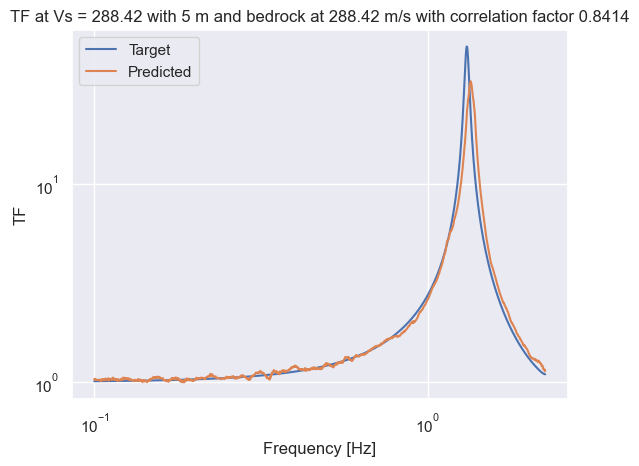

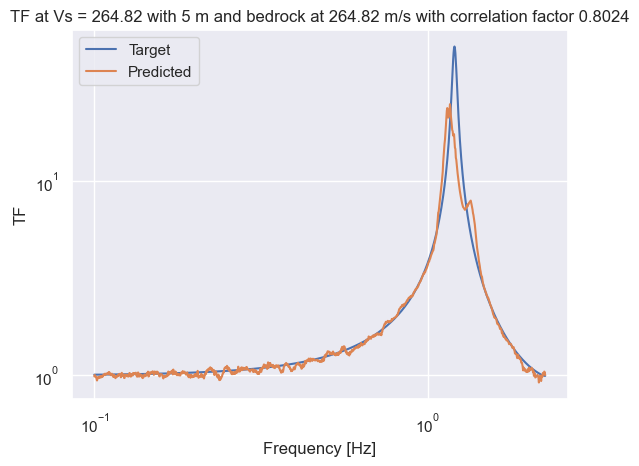

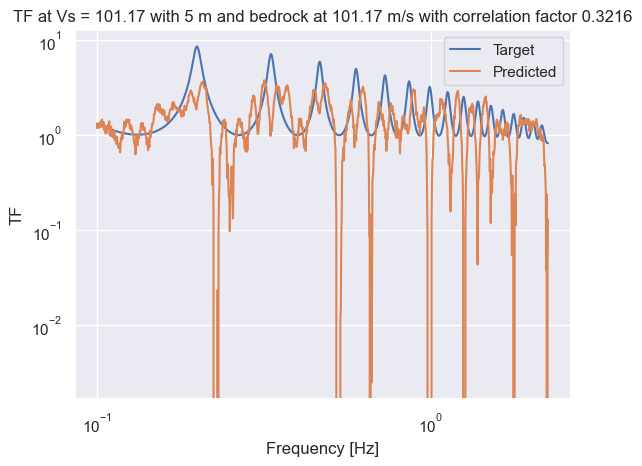

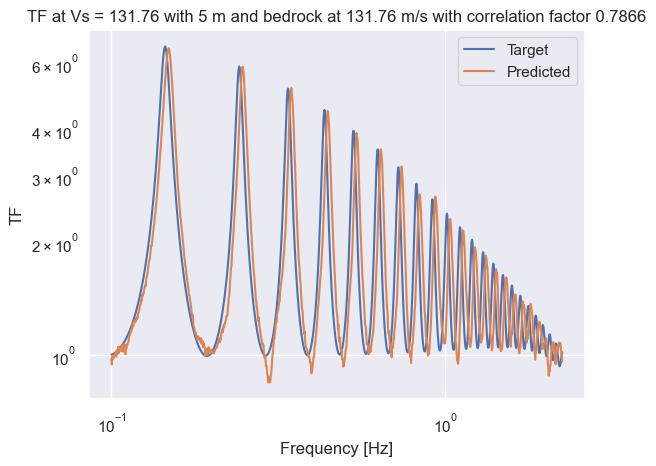

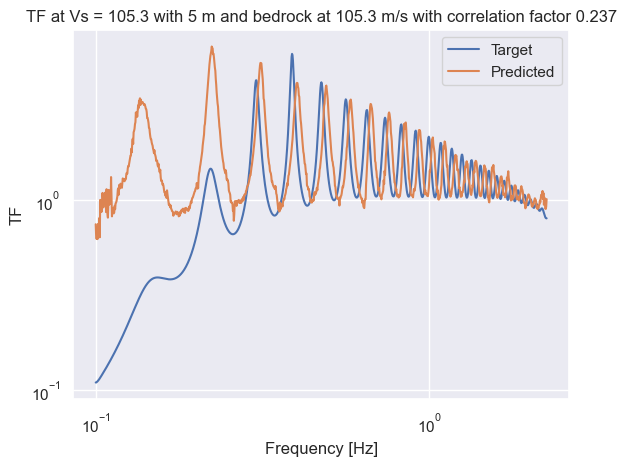

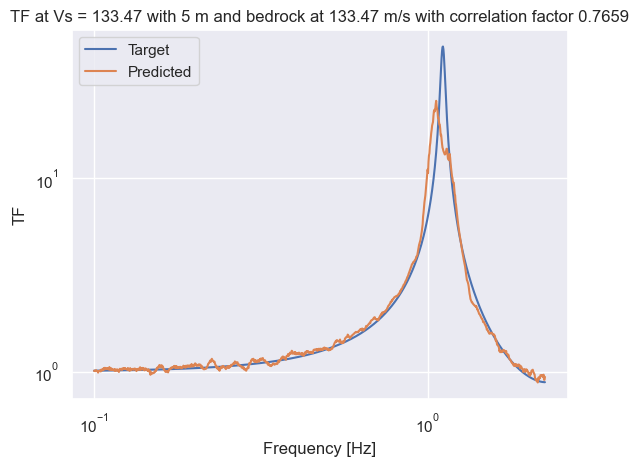

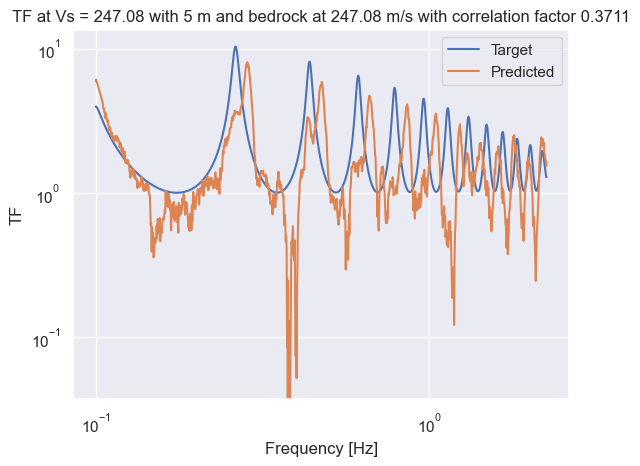

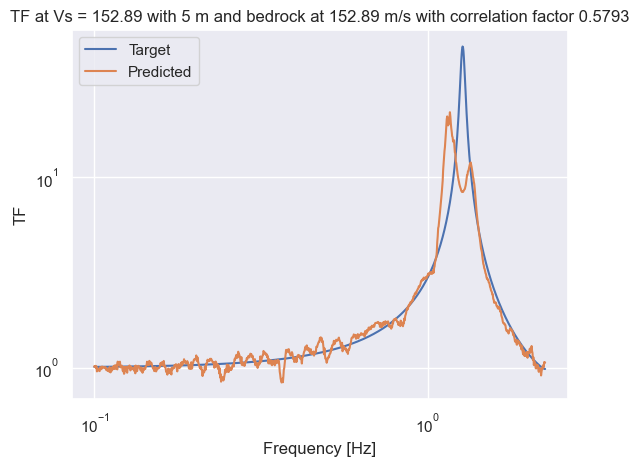

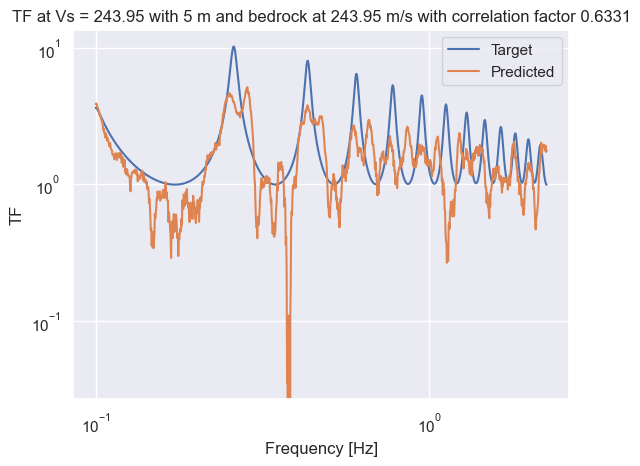

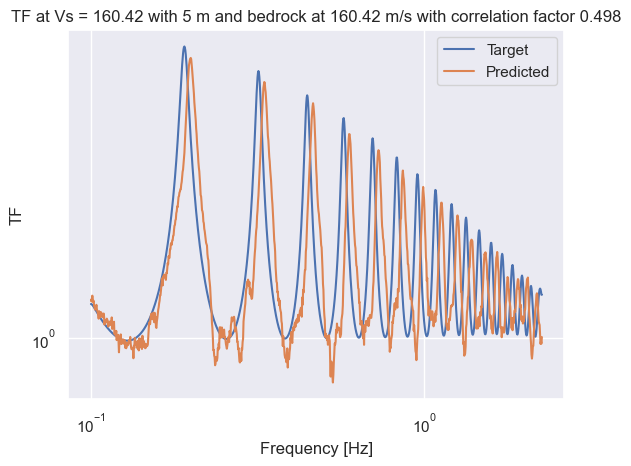

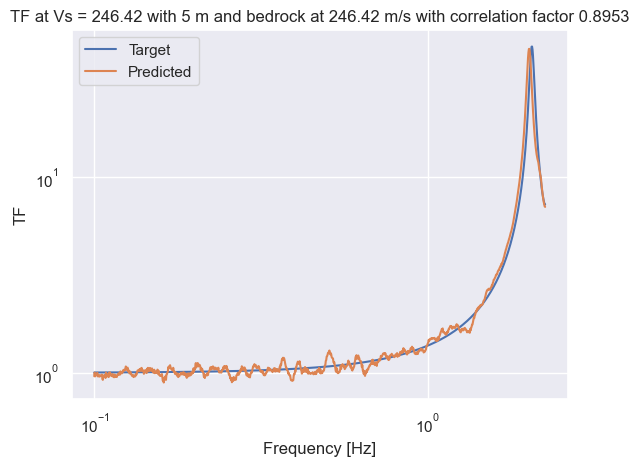

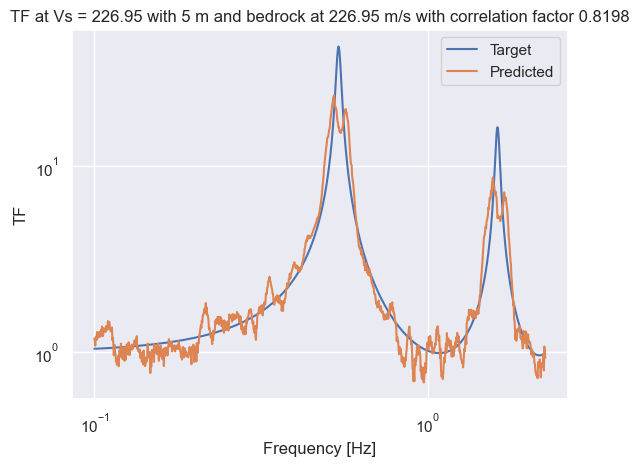

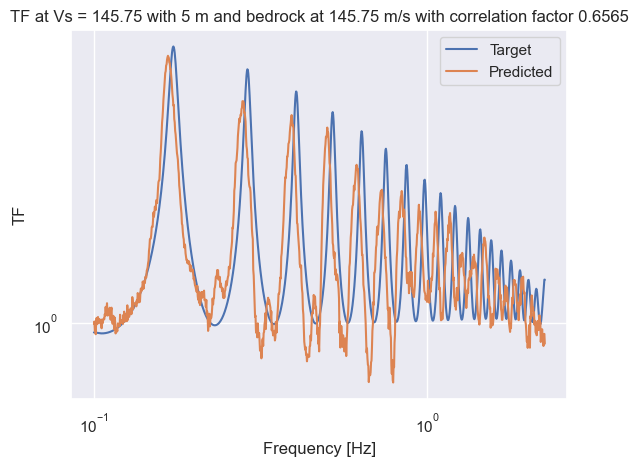

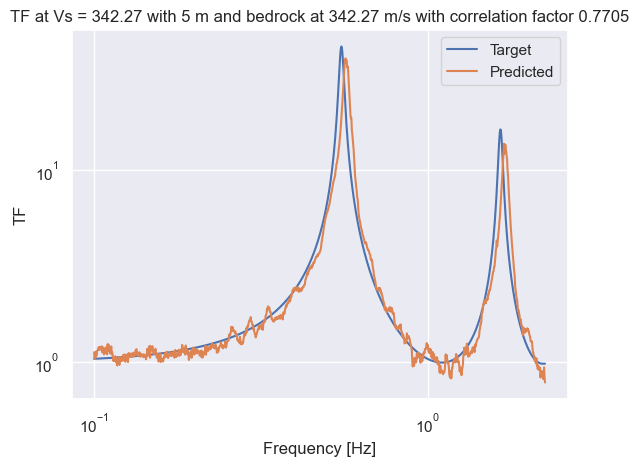

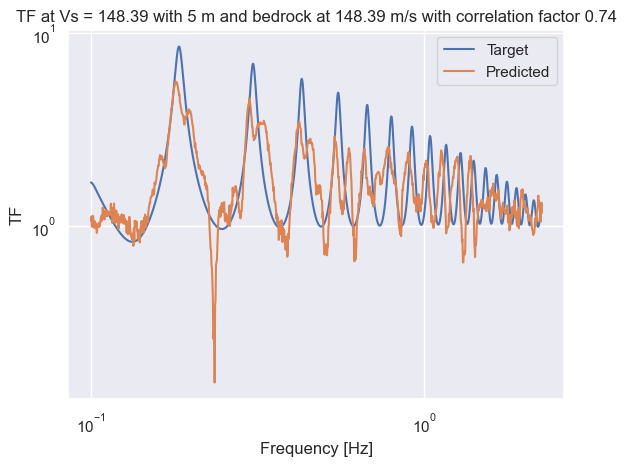

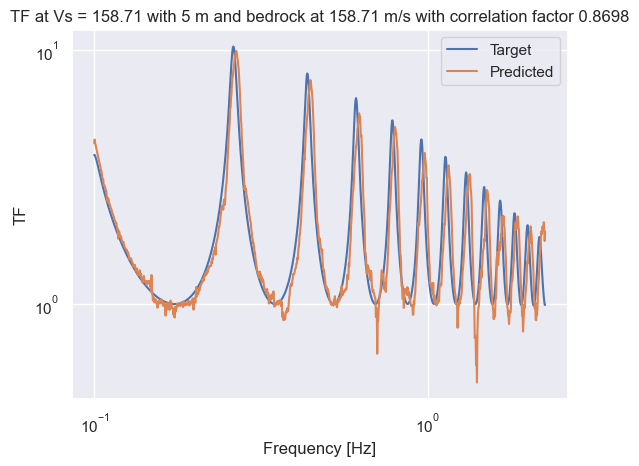

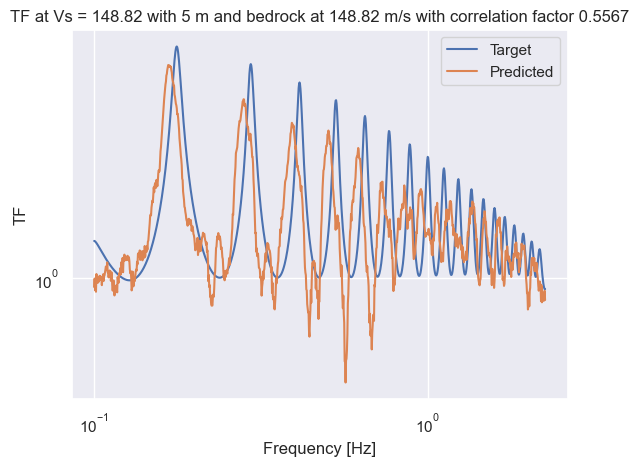

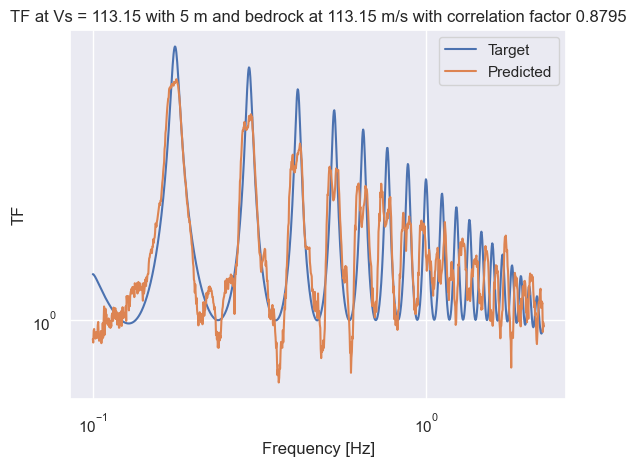

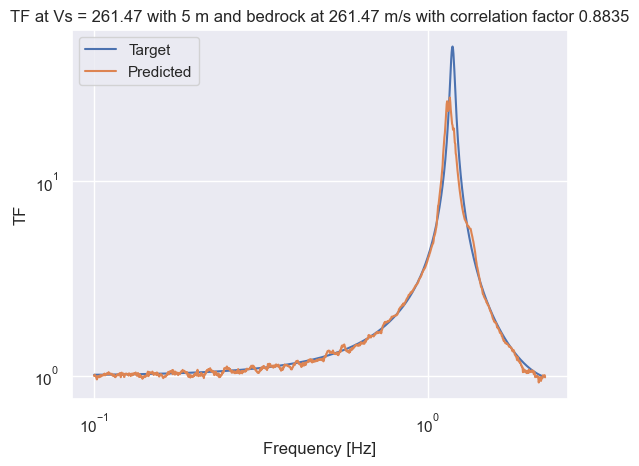

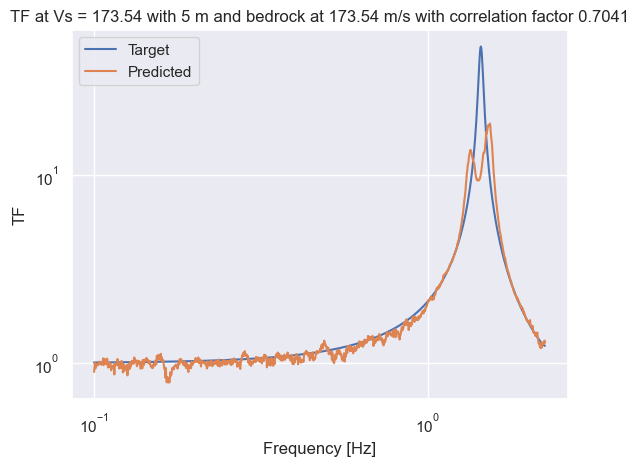

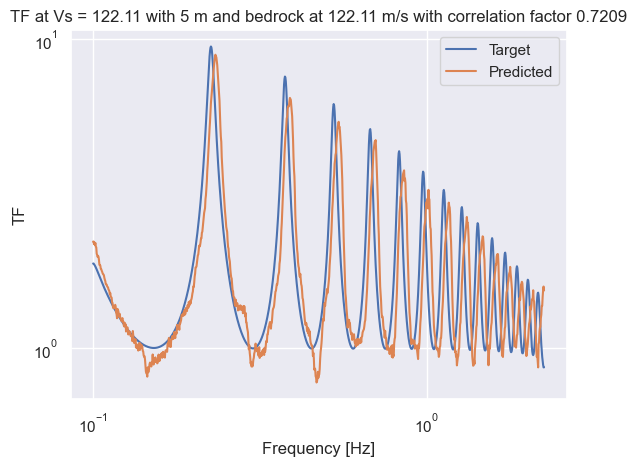

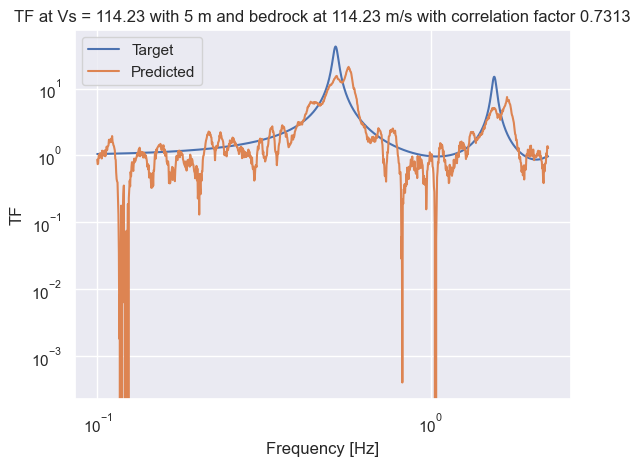

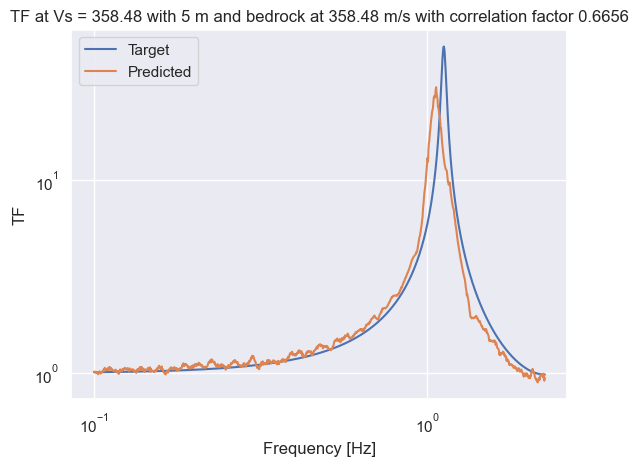

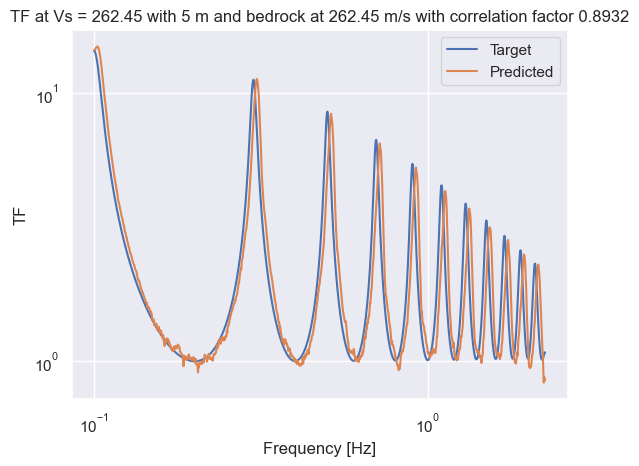

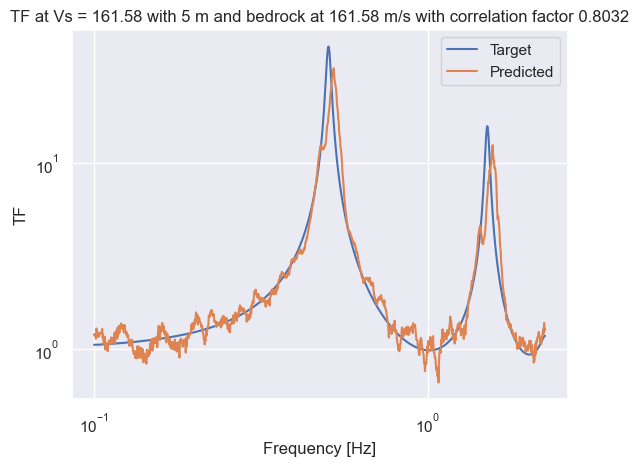

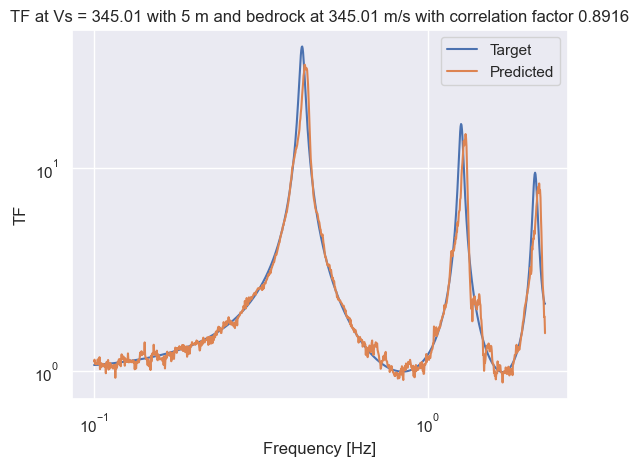

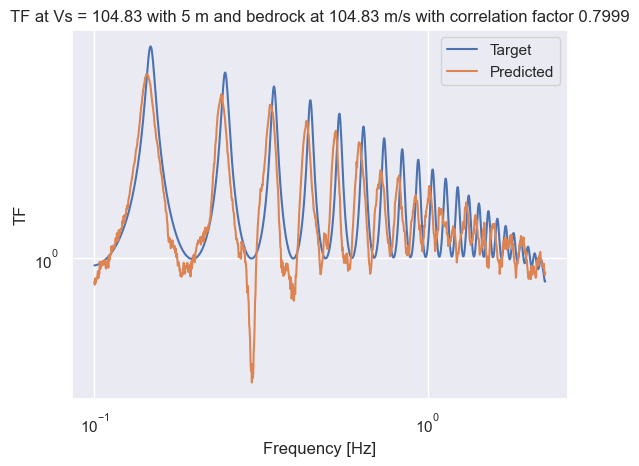

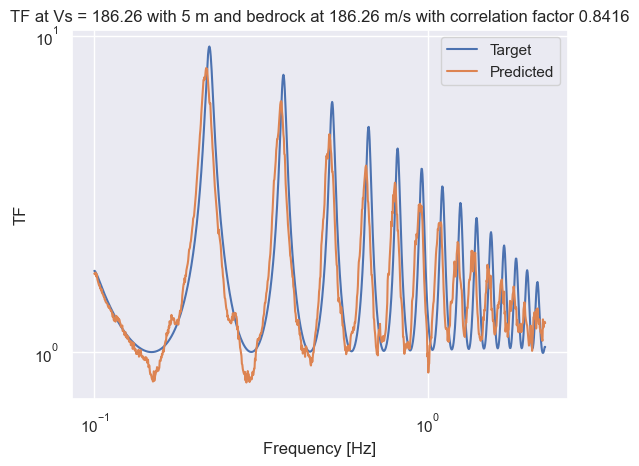

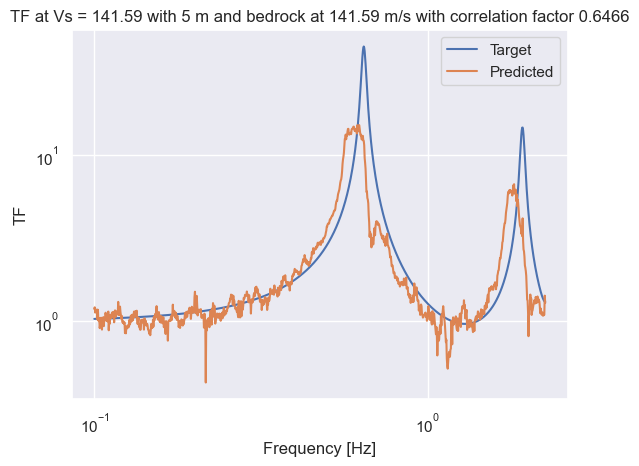

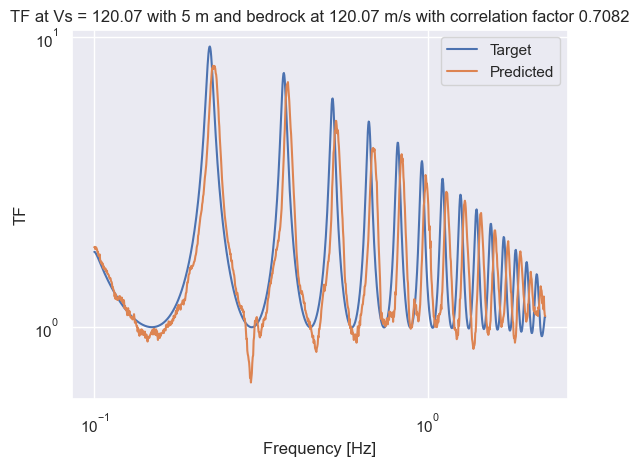

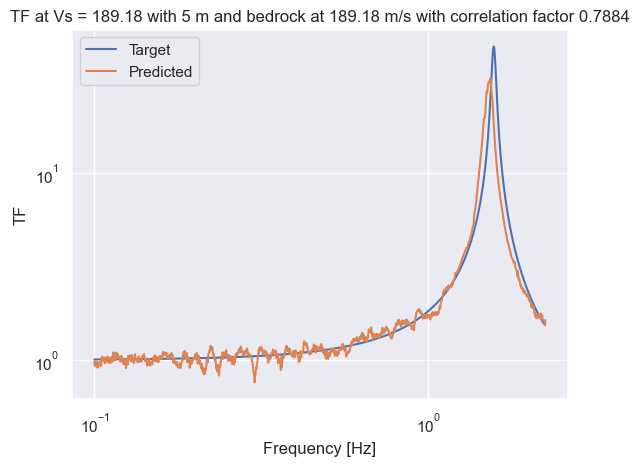

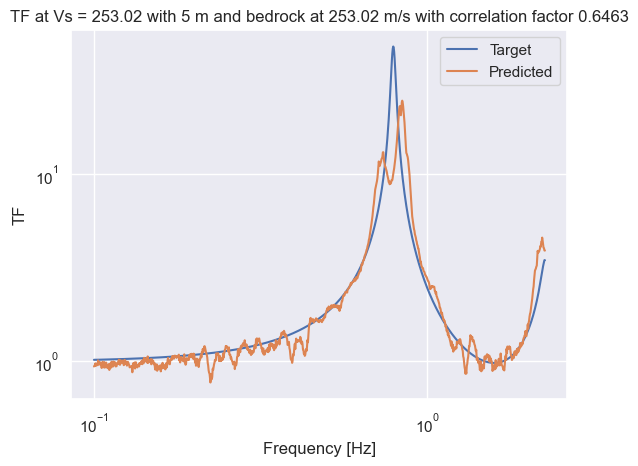

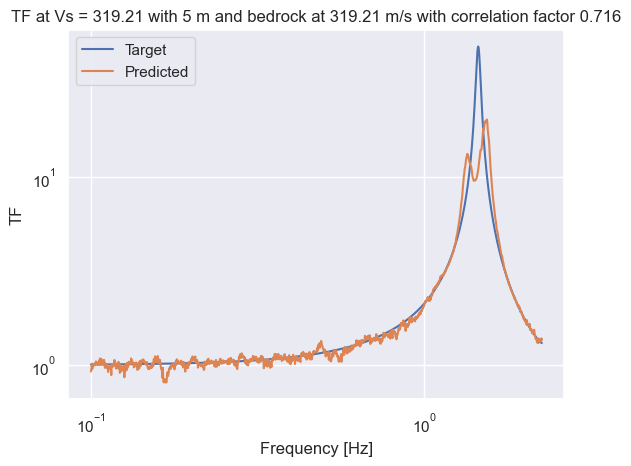

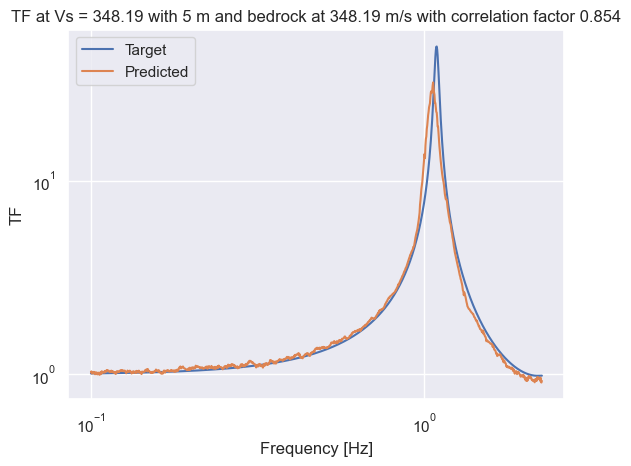

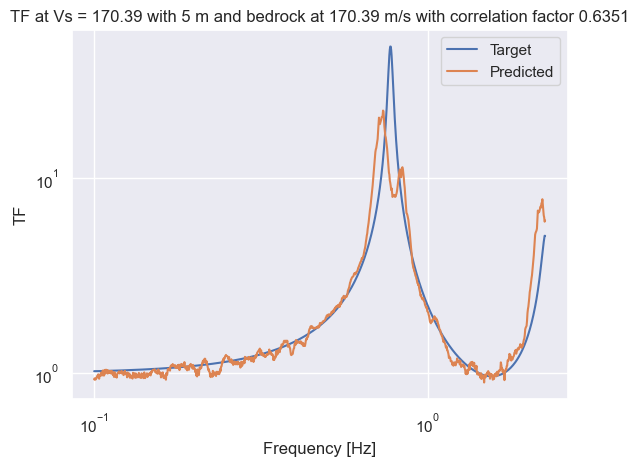

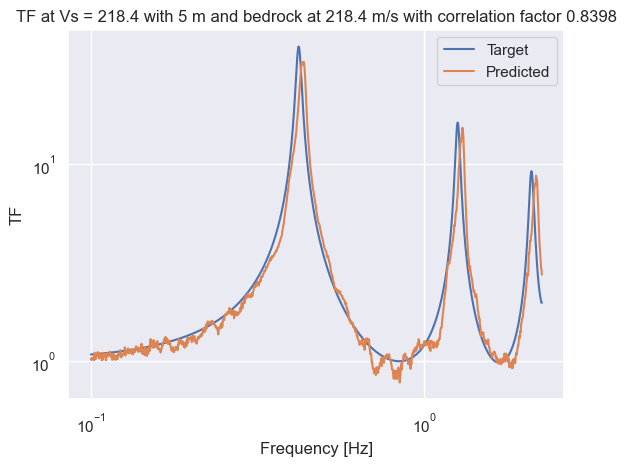

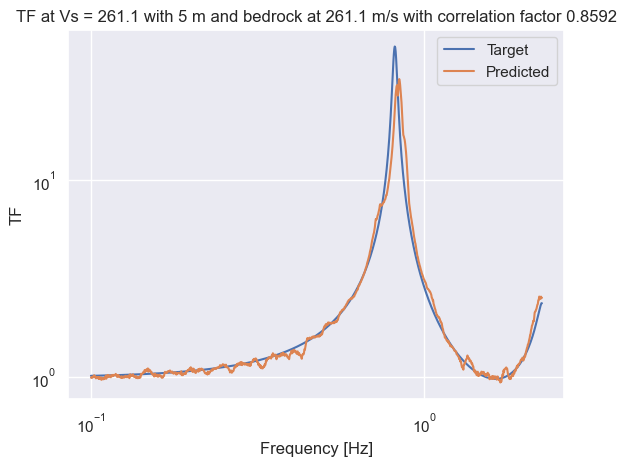

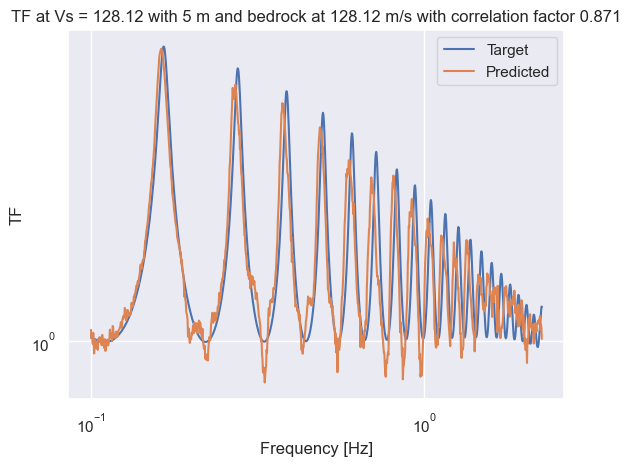

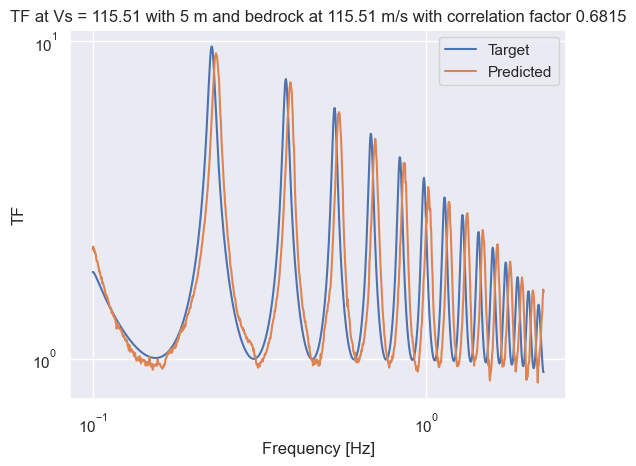

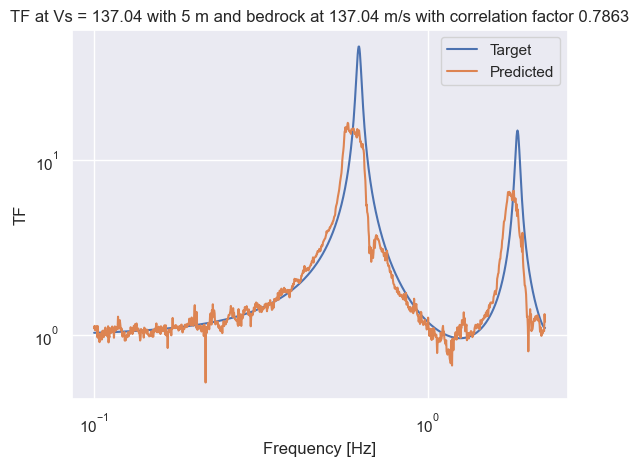

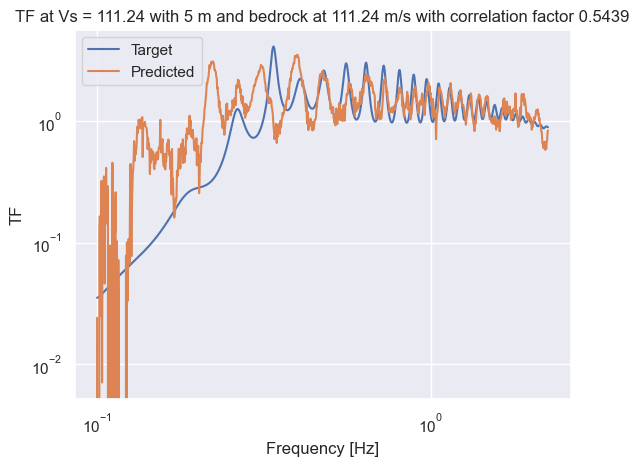

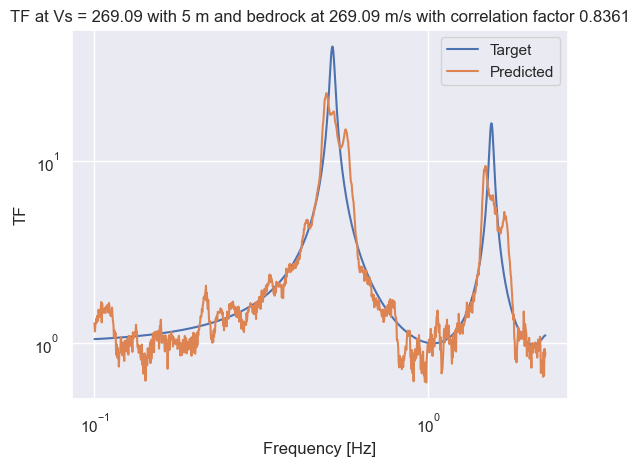

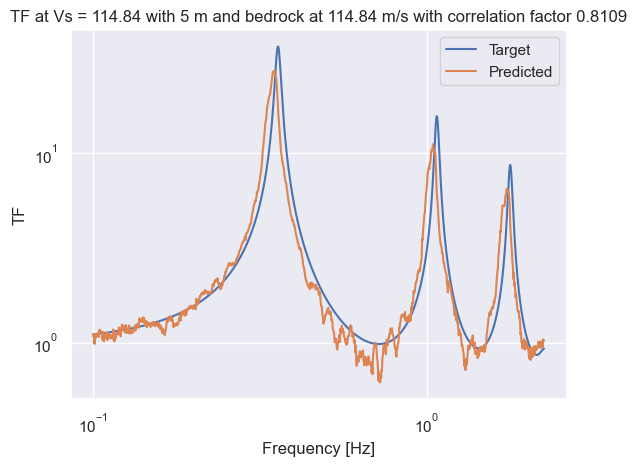

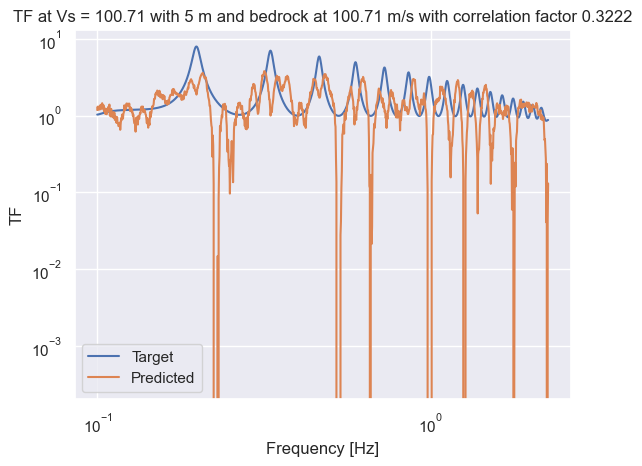

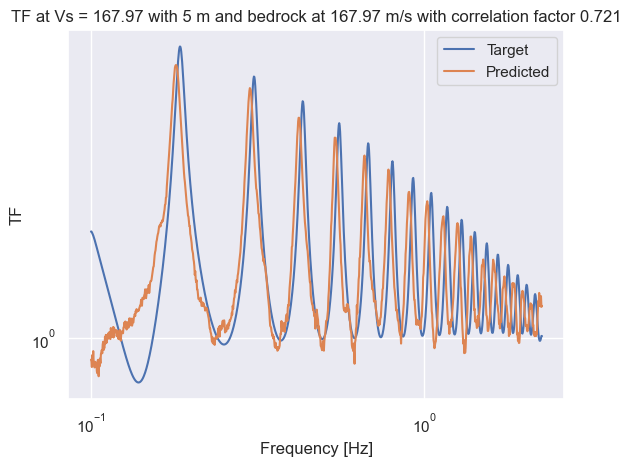

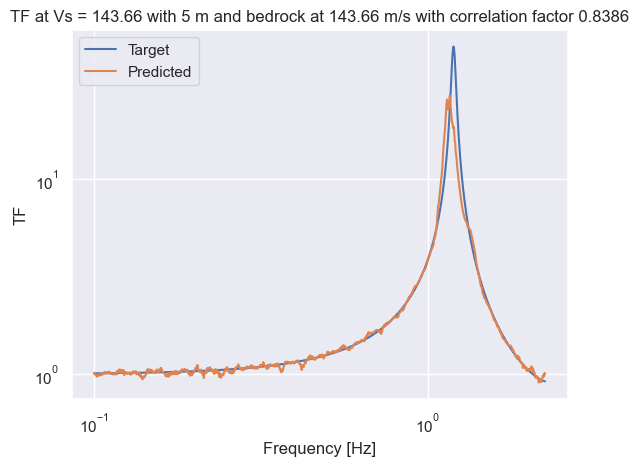

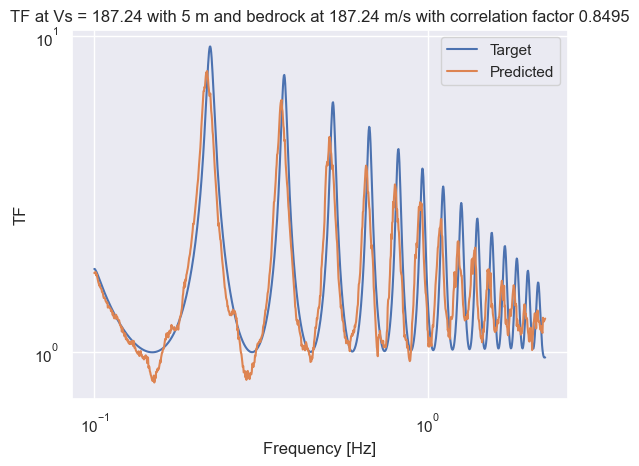

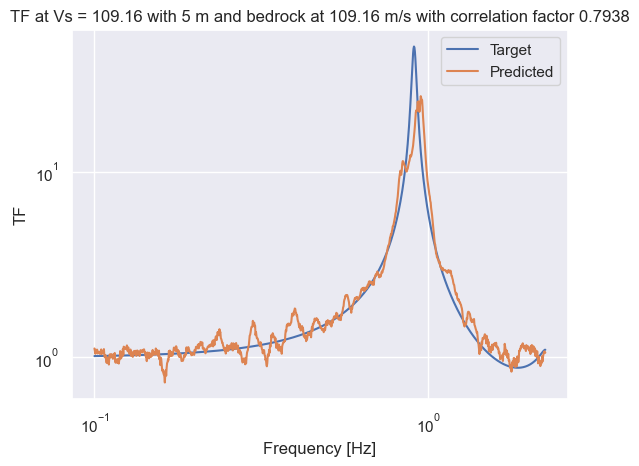

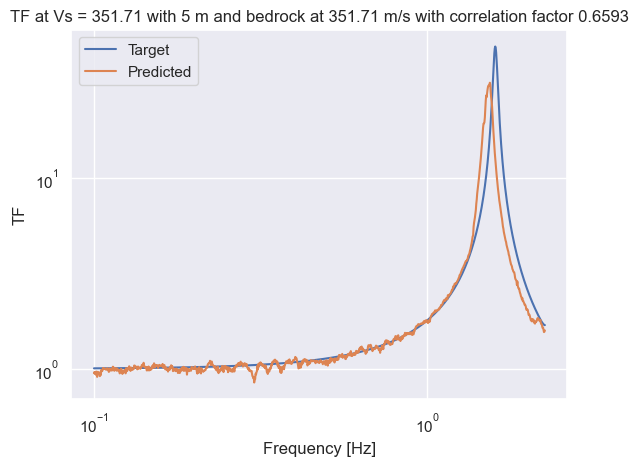

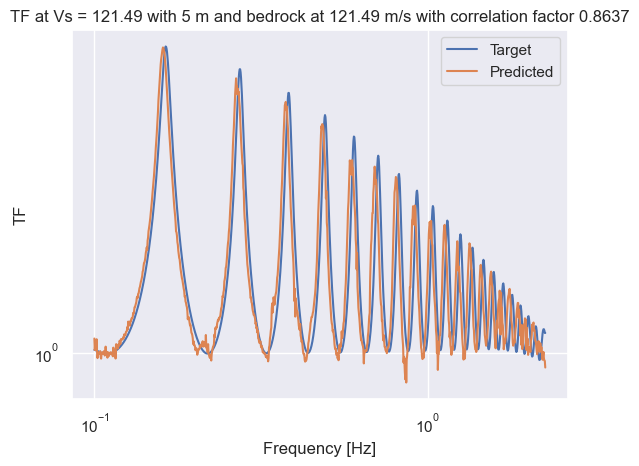

In [34]:
for i in range(target.shape[0]):
    if corr_array[i] < 0.9:
        text_Vs = Vs_data[i,0,:]
        text_Vs = text_Vs[ text_Vs != 0]
        plt.loglog(freq_data, target[i,:], label="Target")
        plt.loglog(freq_data, predicted[i,:], label="Predicted")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TF")
        plt.title("TF at Vs = " + str(round(text_Vs[0],2)) + " with " + str(len(text_Vs)*5) + " m and bedrock at " + str(round(text_Vs[-1],2)) 
        + " m/s" + " with correlation factor " + str(round(corr_array[i],4)))
        plt.legend()
        plt.show()
    else:
        continue


# Checking

In [35]:
# Create a lodaer for the whole dataset
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)

correlations = []
Vs_soil_range = []
Vs_bedrock_range = []
h_soil = []
predicted = []
target = []

with torch.no_grad():
    for X, y in all_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalized_TTF_data:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        correlations.append(pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])
        text_Vs = X.cpu().numpy().flatten()
        text_Vs = text_Vs[text_Vs != 0]
        Vs_soil_range.append(text_Vs[0])
        h_soil.append(len(text_Vs[:-1])*5)
        Vs_bedrock_range.append(text_Vs[-1])
        predicted.append(y_pred.cpu().numpy().squeeze())
        target.append(y.cpu().numpy().squeeze())

correlations = np.array(correlations)
Vs_soil_range = np.array(Vs_soil_range)
Vs_bedrock_range = np.array(Vs_bedrock_range)
predicted = np.array(predicted)
target = np.array(target)

print(correlations.shape, Vs_soil_range.shape, Vs_bedrock_range.shape, predicted.shape, target.shape)



(1000,) (1000,) (1000,) (1000, 1000) (1000, 1000)


In [36]:
# Save correlation results

np.savetxt(os.path.join(path,"correlations.csv"), correlations, delimiter=",")
np.savetxt(os.path.join(path,"Vs_soil_range.csv"), Vs_soil_range, delimiter=",")
np.savetxt(os.path.join(path,"Vs_bedrock_range.csv"), Vs_bedrock_range, delimiter=",")
np.savetxt(os.path.join(path,"h_soil_range.csv"), h_soil, delimiter=",")

np.savetxt(os.path.join(path, "TTF_target_try_1.csv"), predicted, delimiter=",")

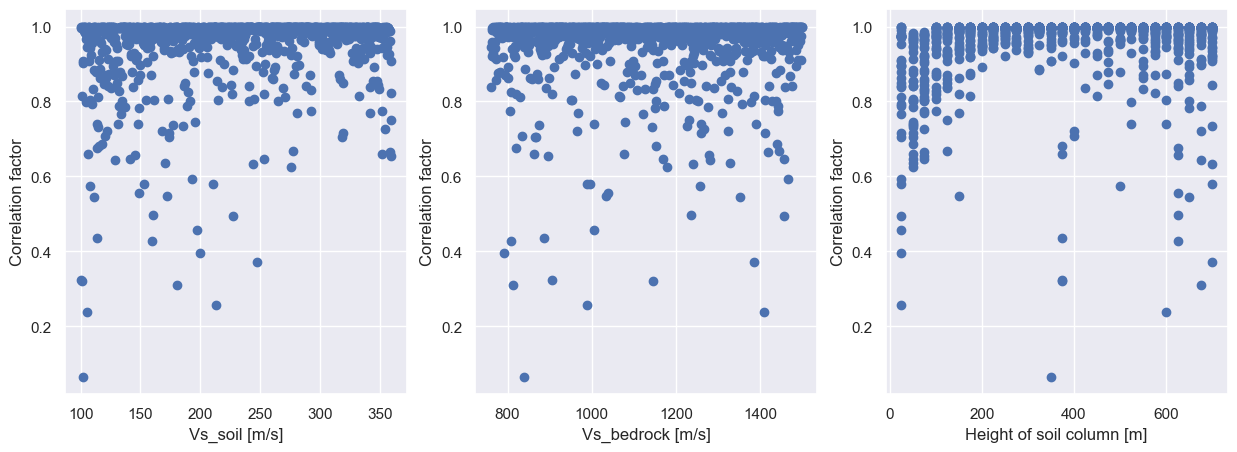

In [37]:
# Plot where x is Vs_soil, Vs_bedrock or height of soil column and y is correlation factor
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(Vs_soil_range, correlations)
ax[0].set_xlabel("Vs_soil [m/s]")
ax[0].set_ylabel("Correlation factor")

ax[1].scatter(Vs_bedrock_range, correlations)
ax[1].set_xlabel("Vs_bedrock [m/s]")
ax[1].set_ylabel("Correlation factor")

ax[2].scatter(h_soil, correlations)
ax[2].set_xlabel("Height of soil column [m]")
ax[2].set_ylabel("Correlation factor")

plt.show()





In [38]:
# 